In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt




2025-06-05 19:03:10.350565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-05 19:03:10.350724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-05 19:03:10.463528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 19:03:10.693784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-05 19:03:12.686785: W tensorflow/compiler/tf2

In [2]:
df2 = pd.read_csv('/notebooks/FallDet/fall_detection_balanced.csv')

In [3]:
df2.drop(columns=['source'], inplace=True)

label
walking     31140
kneeling    31140
falling     31140
Name: count, dtype: int64


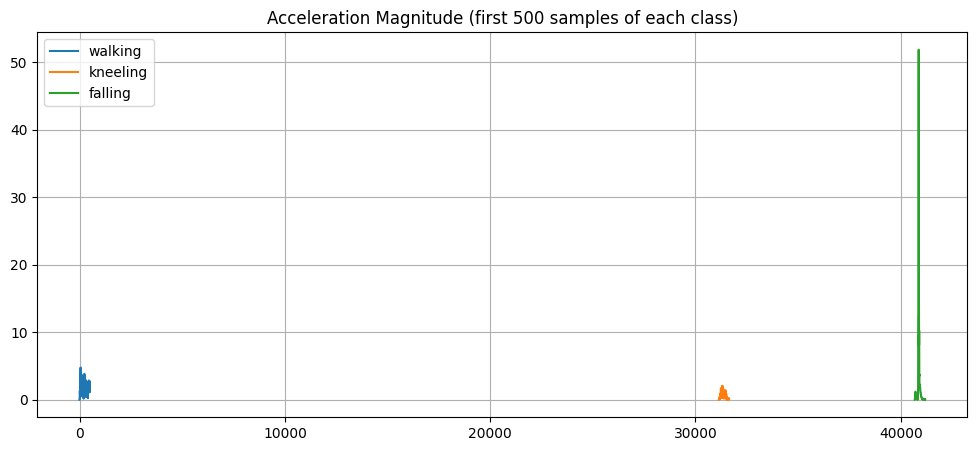

In [ ]:
# Compute acceleration magnitude
df2['acc_mag'] = np.sqrt(df2['ax']**2 + df2['ay']**2 + df2['az']**2)
df2['gyro_mag'] = np.sqrt(df2['gx']**2 + df2['gy']**2 + df2['gz']**2)
df2['acc_mag_std_50'] = df2['acc_mag'].rolling(window=50).std().fillna(0)
df2['gyro_mag_std_50'] = df2['gyro_mag'].rolling(window=50).std().fillna(0)
df2['acc_mag_mean_50'] = df2['acc_mag'].rolling(window=50).mean().fillna(0)
df2['gyro_mag_mean_50'] = df2['gyro_mag'].rolling(window=50).mean().fillna(0)

# Show balance of each class
print(df2['label'].value_counts())

# Quick visualization of magnitude
plt.figure(figsize=(12, 5))
for label in df2['label'].unique():
    plt.plot(df2[df2['label'] == label]['acc_mag'].iloc[:500], label=label)
plt.title('Acceleration Magnitude (first 500 samples of each class)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
df2.head()

,time,ax,ay,az,wx,wy,wz,label,acc_mag
0,0.079624,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,walking,0.000000
1,0.138524,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,walking,0.000000
2,0.139626,0.0000,0.0000,0.0000,0.6282,-0.2318,0.0092,walking,0.000000
3,0.140698,0.0000,0.0000,0.0000,0.6282,-0.2318,0.0092,walking,0.000000
4,0.179147,0.1577,0.0921,0.7286,0.6282,-0.2318,0.0092,walking,0.751139


In [7]:
# Function to create windowed dataset as in the original notebook
def create_windowed_dataset(data, target, window=100, step=1):
    Xs, ys = [], []
    for i in range(0, len(data) - window, step):
        v = data.iloc[i : (i + window)].values
        labels = target.iloc[i : i + window]
        Xs.append(v)
        ys.append(labels.mode()[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)


In [9]:
# Create feature and target datasets
# Selecting all columns except 'label' for features
data = df2.drop(columns=["label"])
target = df2["label"]


In [8]:
# Create windowed dataset
X_train, y_train = create_windowed_dataset(data, target, window=100, step=1)
# Convert labels to one-hot encoding
classes = sorted(list(set(y_train.flatten())))  # Get unique classes
y_train = label_binarize(y_train, classes=classes)


In [ ]:
# Step 11: Create test data and evaluate the model
X_test, y_test = create_windowed_dataset(data, target, window=100, step=1)
y_test = label_binarize(y_test, classes=classes)

# Correct the problematic line - don't split X_test again and don't use [2:]
# Just use the test set as is, or if you need a separate test set:
X_test_eval, X_holdout, y_test_eval, y_holdout = train_test_split(
    X_test, y_test, test_size=0.2, random_state=42
)

# Verify the shapes to ensure they're correct for the model
print(f"X_test_eval shape: {X_test_eval.shape}")

# Make predictions - use X_test_eval, which should maintain the 3D shape
test_predictions = model.predict(X_test_eval)

# Evaluate accuracy
test_accuracy = accuracy_score(y_test_eval.argmax(axis=1), test_predictions.argmax(axis=1))
print(f"Test accuracy: {test_accuracy:.4f}")

# Print classification report
y_pred_classes = test_predictions.argmax(axis=1)
y_true_classes = y_test_eval.argmax(axis=1)
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Print confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Save the model in SavedModel format
model.save("fall_detection_gru_saved_model.h5")
print("Model saved as 'fall_detection_gru_saved_model.h5'")

# Example of how to make a prediction on a single window of data
def predict_activity(model, data_window, classes):
    """
    Predict activity from a single window of sensor data.

    Parameters:
    - model: Trained Keras model
    - data_window: Numpy array of shape (window_size, n_features)
    - classes: List of class names

    Returns:
    - predicted_class: Predicted activity class
    - confidence: Confidence score (probability)
    """
    # Expand dimensions to create a batch of size 1
    data_batch = np.expand_dims(data_window, axis=0)

    # Make prediction
    prediction = model.predict(data_batch)

    # Get the predicted class index and confidence
    predicted_index = np.argmax(prediction[0])
    confidence = prediction[0][predicted_index]

    return classes[predicted_index], confidence

# Example usage (you would replace this with your actual test data)
sample_window = X_test_eval[0]  # Take the first window from test data
predicted_class, confidence = predict_activity(model, sample_window, classes)
print(f"Predicted activity: {predicted_class} with confidence: {confidence:.4f}")

In [ ]:
import tensorflow as tf
import numpy as np

# Method 1: Try loading with custom objects first
def custom_gru(*args, **kwargs):
    kwargs.pop('batch_input_shape', None)
    kwargs.pop('time_major', None)
    return tf.keras.layers.GRU(*args, **kwargs)

def custom_bidirectional(*args, **kwargs):
    kwargs.pop('batch_input_shape', None)
    kwargs.pop('time_major', None)
    return tf.keras.layers.Bidirectional(*args, **kwargs)

try:
    # Try loading with custom objects
    model_path = '/content/fall_detection_gru_new_data.h5'
    loaded_model = tf.keras.models.load_model(
        model_path,
        custom_objects={
            'GRU': custom_gru,
            'Bidirectional': custom_bidirectional
        }
    )
    print("Model loaded successfully with custom objects!")

except Exception as e:
    print(f"Custom objects approach failed: {e}")
    print("Trying alternative approach...")

In [ ]:
def test_specific_range(model_path, test_data_path, start_index, end_index, label_column=None):
    """
    Test a specific range of data from a CSV file.

    Parameters:
    - model_path: Path to the saved model
    - test_data_path: Path to the test CSV file
    - start_index: Start index of the range to test
    - end_index: End index of the range to test
    - label_column: Name of the label column (if exists, otherwise None)
    """
    # Load the model
    model = keras.models.load_model(model_path)
    print(f"Loaded model from {model_path}")

    # Load the data
    df = pd.read_csv(test_data_path)
    print(f"Loaded {len(df)} samples from {test_data_path}")
    print(f"Available columns: {df.columns.tolist()}")

    # Reset index if needed
    if not df.index.is_monotonic_increasing or not df.index.equals(pd.RangeIndex(len(df))):
        df = df.reset_index(drop=True)

    # Ensure the range is valid
    if end_index > len(df):
        raise ValueError(f"Range exceeds dataset size. Maximum allowable end index: {len(df) - 1}")

    # Check required columns
    required_features = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'acc_mag', 'gyro_mag',
            'acc_mag_std_50', 'gyro_mag_std_50', 'acc_mag_mean_50', 'gyro_mag_mean_50']
    missing_features = [col for col in required_features if col not in df.columns]

    if missing_features:
        print(f"Warning: Missing required feature columns: {missing_features}")
        print("Please check your CSV file format and column names")
        return None, None, None

    # Add acc_mag if it doesn't exist
    if 'acc_mag' not in df.columns:
        df['acc_mag'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)

    # Extract sample features
    feature_columns = ['ax', 'ay', 'az', 'wx', 'wy', 'wz', 'acc_mag']
    sample = df.iloc[start_index:end_index][feature_columns]

    # Get true label if label column exists
    true_label = None
    if label_column is not None and label_column in df.columns:
        true_label = df.iloc[start_index:end_index][label_column].mode()[0]
        print(f"True label: {true_label}")
    else:
        print("No label column found in the data. Only prediction will be performed.")

    # Prepare the sample for prediction
    sample_batch = np.expand_dims(sample.values, axis=0)

    # Verify shape matches model's expected input
    input_shape = model.layers[0].input_shape
    print(f"Model expects input shape: {input_shape}")
    print(f"Sample batch shape: {sample_batch.shape}")

    # Predict using the trained model
    prediction = model.predict(sample_batch)

    # Get the class names (assuming they match the order in your training data)
    # You may need to adjust this based on your model's output
    classes = ['walking', 'falling', 'kneeling']  # Update with your actual classes

    # Get predicted class and confidence
    predicted_class_index = prediction.argmax(axis=1)[0]
    predicted_class = classes[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    # Print results
    print(f"\nPrediction Results:")
    print(f"Predicted activity: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")

    if true_label is not None:
        print(f"Correct: {predicted_class == true_label}")

    # Print full prediction distribution
    print("\nPrediction distribution:")
    for i, cls in enumerate(classes):
        print(f"{cls}: {prediction[0][i]:.4f}")

    # Plot sample data
    plt.figure(figsize=(15, 10))

    # Plot accelerometer data
    plt.subplot(2, 1, 1)
    plt.plot(sample['ax'], label='ax')
    plt.plot(sample['ay'], label='ay')
    plt.plot(sample['az'], label='az')
    plt.plot(sample['acc_mag'], label='acc_mag', linewidth=2, color='black')

    if true_label is not None:
        plt.title(f'Accelerometer Data (True: {true_label}, Predicted: {predicted_class})')
    else:
        plt.title(f'Accelerometer Data (Predicted: {predicted_class})')

    plt.legend()
    plt.grid(True)

    # Plot gyroscope data
    plt.subplot(2, 1, 2)
    plt.plot(sample['wx'], label='wx')
    plt.plot(sample['wy'], label='wy')
    plt.plot(sample['wz'], label='wz')
    plt.title('Gyroscope Data')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('sample_prediction.png')
    plt.show()

    return predicted_class, confidence, true_label

# Example usage:
if __name__ == "__main__":
    # Test on a specific range without requiring a label column
    predicted_class, confidence, true_label = test_specific_range(
        model_path="/notebooks/FallDet/fall_detection_gru_saved_model.h5",
        test_data_path="/notebooks/FallDet/Mark - falling test 1.csv",
        start_index=250,
        end_index=400,
        label_column=None  # Set to None since 'label' doesn't exist
    )

NameError: name 'keras' is not defined

Creating windowed dataset with change detection features...
Enhanced features shape: (74656, 100, 17)
Labels shape: (74656, 3)
Classes: ['falling', 'kneeling', 'walking']
Features per timestep: 17


2025-06-05 19:06:29.973148: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-05 19:06:30.150700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-05 19:06:30.150973: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

L355
2025-06-05 19:06:30.409972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-05 19:06:30.410162: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-05 19:06:30.410292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15657 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0, compute capability: 6.1


Class weights: {0: 1.000294771819814, 1: 1.003076840393943, 2: 0.9966491783144432}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               31872     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)

2025-06-05 19:06:37.945897: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f50f6a54030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-05 19:06:37.945964: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P5000, Compute Capability 6.1
2025-06-05 19:06:37.971802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-05 19:06:38.023426: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1749150398.143656     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2333/2333 [==============================] - 482s 204ms/step - loss: 2.6387 - acc: 0.3537 - val_loss: 2.0905 - val_acc: 0.4390 - lr: 5.0000e-05
Epoch 2/50
2333/2333 [==============================] - 476s 204ms/step - loss: 2.0358 - acc: 0.3695 - val_loss: 1.8231 - val_acc: 0.6170 - lr: 5.0000e-05
Epoch 3/50
2333/2333 [==============================] - 475s 204ms/step - loss: 1.7338 - acc: 0.4047 - val_loss: 1.5307 - val_acc: 0.6029 - lr: 5.0000e-05
Epoch 4/50
2333/2333 [==============================] - 478s 205ms/step - loss: 1.4770 - acc: 0.4609 - val_loss: 1.1794 - val_acc: 0.6051 - lr: 5.0000e-05
Epoch 5/50
2333/2333 [==============================] - 473s 203ms/step - loss: 1.2130 - acc: 0.5383 - val_loss: 0.9003 - val_acc: 0.6209 - lr: 5.0000e-05
Epoch 6/50
2333/2333 [==============================] - 475s 204ms/step - loss: 0.9871 - acc: 0.6002 - val_loss: 0.8059 - val_acc: 0.6318 - lr: 5.0000e-05
Epoch 7/50
2333/2333 [==============================] - 476s 204ms/step - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


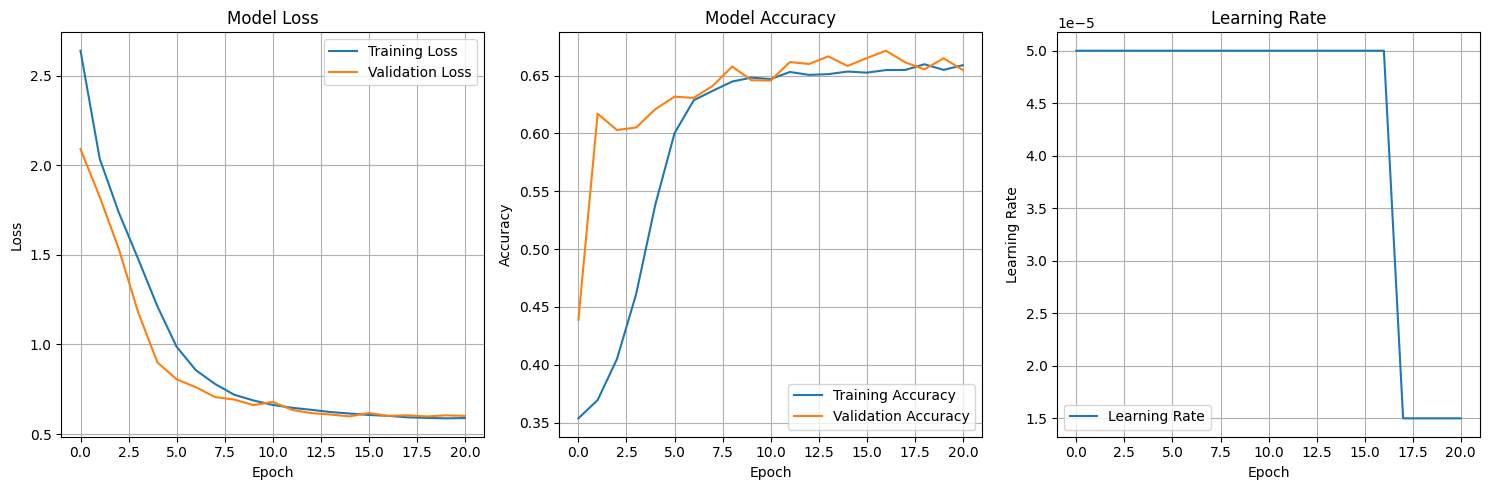


ANTI-OVERFITTING MODEL COMPLETE!
Key improvements:
1. ✓ Higher dropout rates (0.5-0.8)
3. ✓ Lower learning rate (0.00005)
4. ✓ L2 regularization on all layers
5. ✓ Smaller network architecture
6. ✓ Multiple early stopping criteria
7. ✓ Class-weighted training

Expected results:
- Much better generalization to real data
- Lower overfitting
- More reliable fall detection


In [5]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Step 1: Load and prepare your data
# df2 = pd.read_csv('your_data.csv')  # Uncomment and load your data

# Step 2: Define the feature columns to use
features = ['ax', 'ay', 'az', 'wx', 'wy', 'wz', 'acc_mag']
label_column = 'label'

# Step 3: Enhanced windowed dataset function with change detection
def create_windowed_dataset_with_changes(data, target, window=100, step=1):
    """
    Create windowed dataset with additional features for detecting drastic changes.
    """
    Xs, ys = [], []
    for i in range(0, len(data) - window, step):
        window_data = data.iloc[i : (i + window)]
        labels = target.iloc[i : i + window]
        
        # Original features
        v = window_data.values
        
        # Calculate change features for this window
        change_features = calculate_change_features(window_data)
        
        # Append change features to each timestep
        enhanced_features = np.concatenate([v, np.tile(change_features, (window, 1))], axis=1)
        
        Xs.append(enhanced_features)
        ys.append(labels.mode()[0])
    
    return np.array(Xs), np.array(ys).reshape(-1, 1)

def calculate_change_features(window_data):
    """
    Calculate drastic change indicators for a window of sensor data.
    """
    features = []
    
    # 1. Maximum acceleration magnitude
    acc_mag = np.sqrt(window_data['ax']**2 + window_data['ay']**2 + window_data['az']**2)
    max_acc = acc_mag.max()
    features.append(max_acc)
    
    # 2. Maximum change in acceleration magnitude
    acc_diff = acc_mag.diff().abs().max()
    features.append(acc_diff if not np.isnan(acc_diff) else 0)
    
    # 3. Standard deviation of acceleration
    acc_std = acc_mag.std()
    features.append(acc_std if not np.isnan(acc_std) else 0)
    
    # 4. Maximum rotational velocity
    max_gyro = max(window_data['wx'].abs().max(), 
                   window_data['wy'].abs().max(), 
                   window_data['wz'].abs().max())
    features.append(max_gyro)
    
    # 5. Free fall indicator (minimum acceleration)
    min_acc = acc_mag.min()
    features.append(min_acc)
    
    # 6. Impact indicator
    acc_values = acc_mag.values
    impact_score = 0
    for i in range(1, len(acc_values)):
        if acc_values[i-1] < 5.0 and acc_values[i] > 12.0:
            impact_score = max(impact_score, acc_values[i] - acc_values[i-1])
    features.append(impact_score)
    
    # 7. Change rate in X, Y, Z accelerations
    ax_change = window_data['ax'].diff().abs().max()
    ay_change = window_data['ay'].diff().abs().max()
    az_change = window_data['az'].diff().abs().max()
    features.extend([
        ax_change if not np.isnan(ax_change) else 0,
        ay_change if not np.isnan(ay_change) else 0,
        az_change if not np.isnan(az_change) else 0
    ])
    
    # 8. Fall pattern score
    fall_score = 0
    if max_acc > 15.0:
        fall_score += 0.3
    if min_acc < 3.0:
        fall_score += 0.25
    if acc_diff > 8.0:
        fall_score += 0.25
    if max_gyro > 3.0:
        fall_score += 0.2
    features.append(fall_score)
    
    return np.array(features).reshape(1, -1)

# Step 4: Prepare the data with enhanced features
data = df2[features]
target = df2[label_column]

# Step 5: Create windowed dataset with change detection
print("Creating windowed dataset with change detection features...")
X_train, y_train = create_windowed_dataset_with_changes(data, target, window=100, step=1)

# Step 6: Get unique classes and perform one-hot encoding
classes = sorted(df2[label_column].unique())
y_train = label_binarize(y_train, classes=classes)

# Step 7: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print information about the enhanced dataset
print(f"Enhanced features shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")
print(f"Classes: {classes}")
print(f"Features per timestep: {X_train.shape[2]}")

# COMBINED ANTI-OVERFITTING APPROACH (Fixes 1-5)

# Fix 1: More Aggressive Regularization + Fix 4: L2 Regularization
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.GRU(
            units=64,  # Reduced from 128
            input_shape=[X_train.shape[1], X_train.shape[2]],
            dropout=0.5,  # Increased from 0.3
            recurrent_dropout=0.5,  # Increased from 0.3
            kernel_regularizer=regularizers.l2(0.01)  # L2 regularization
        )
    )
)
model.add(keras.layers.Dropout(rate=0.8))  # Increased from 0.6

model.add(keras.layers.Dense(
    units=32,  # Reduced from 128
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)  # L2 regularization
))
model.add(keras.layers.Dropout(rate=0.7))  # Increased from 0.4

model.add(keras.layers.Dense(
    units=16,  # Additional smaller layer
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)  # L2 regularization
))
model.add(keras.layers.Dropout(rate=0.6))  # Additional dropout

model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train.argmax(axis=1)),
    y=y_train.argmax(axis=1)
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# Fix 3: Reduced Learning Rate
optimizer = Adam(learning_rate=0.00005)  # Reduced from 0.0001
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))
model.summary()

# Fix 2: More Aggressive Early Stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=3,  # Reduced from 7 to 3
#     restore_best_weights=True,
#     verbose=1
# )

# Fix 5: More aggressive learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3,  # More aggressive reduction (was 0.5)
    patience=2,  # Reduced from 4 to 2
    min_lr=0.000001,  # Lower minimum learning rate
    verbose=1
)

# Additional callback: Stop if validation accuracy stops improving
val_acc_early_stop = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

print("Training anti-overfitting model with combined regularization...")
print("Expected behavior:")
#print("- Training should stop early (5-15 epochs)")
print("- Validation loss should stay close to training loss")
print("- Lower final accuracy but better generalization")

# Train the anti-overfitting model
history = model.fit(
    X_train, y_train,
    epochs=50,  # Will likely stop much earlier
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, val_acc_early_stop],
    verbose=1
)

# Evaluate the model
print("\nEvaluating anti-overfitting model...")
X_test, y_test = create_windowed_dataset_with_changes(data, target, window=100, step=50)
X_test_split, X_holdout, y_test_split, y_holdout = train_test_split(
    X_test, y_test, test_size=0.3, random_state=42
)

y_test_split = label_binarize(y_test_split, classes=classes)
test_predictions = model.predict(X_test_split)

test_accuracy = accuracy_score(y_test_split.argmax(axis=1), test_predictions.argmax(axis=1))
print(f"Anti-overfitting model test accuracy: {test_accuracy:.4f}")

# Print classification report
y_pred_classes = test_predictions.argmax(axis=1)
y_true_classes = y_test_split.argmax(axis=1)
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Print training history summary
final_epoch = len(history.history['loss'])
print(f"\nTraining Summary:")
print(f"- Stopped at epoch: {final_epoch}")
print(f"- Final training loss: {history.history['loss'][-1]:.4f}")
print(f"- Final validation loss: {history.history['val_loss'][-1]:.4f}")
print(f"- Final training accuracy: {history.history['acc'][-1]:.4f}")
print(f"- Final validation accuracy: {history.history['val_acc'][-1]:.4f}")
print(f"- Loss gap (val - train): {history.history['val_loss'][-1] - history.history['loss'][-1]:.4f}")

# Save the anti-overfitting model
model.save("anti_overfitting_fall_detection_model.h5")
print("Anti-overfitting model saved as 'anti_overfitting_fall_detection_model.h5'")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot training & validation loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training & validation accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot learning rate
plt.subplot(1, 3, 3)
plt.plot(history.history.get('lr', []), label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('anti_overfitting_training_history.png')
plt.show()

print("\n" + "="*60)
print("ANTI-OVERFITTING MODEL COMPLETE!")
print("="*60)
print("Key improvements:")
print("1. ✓ Higher dropout rates (0.5-0.8)")
#print("2. ✓ Aggressive early stopping (patience=3)")
print("3. ✓ Lower learning rate (0.00005)")
print("4. ✓ L2 regularization on all layers")
print("5. ✓ Smaller network architecture")
print("6. ✓ Multiple early stopping criteria")
print("7. ✓ Class-weighted training")
print("\nExpected results:")
print("- Much better generalization to real data")
print("- Lower overfitting")
print("- More reliable fall detection")
print("="*60)

Enhanced Fall Detection Model Tester
This version includes change detection features and enhanced decision logic

Loaded enhanced model from /notebooks/FallDet/anti_overfitting_fall_detection_model.h5
Loaded 402 samples from Mark - falling test 1.csv
Available columns: ['time', 'ax', 'ay', 'az', 'wx', 'wy', 'wz', 'Unnamed: 7']
No label column found in the data. Only prediction will be performed.
Model expects input shape: (None, 100, 17)
Sample batch shape: (1, 100, 17)
Original features: 7, Enhanced features: 17
1/1 [==============================] - 1s 551ms/step

ENHANCED MODEL PREDICTION RESULTS
Predicted activity: falling
Final confidence: 0.5011

ML Model Probabilities:
  falling: 0.5011
  kneeling: 0.4987
  walking: 0.0002

Change Detection Analysis:
  Max acceleration: 2.20 m/s²
  Min acceleration: 0.00 m/s²
  Max change rate: 1.01 m/s²
  Acceleration std: 0.54 m/s²
  Max gyro: 2.15 rad/s
  Impact score: 0.00
  Fall pattern score: 0.25

Fall Indicators:
  High impact (>15g): Fa

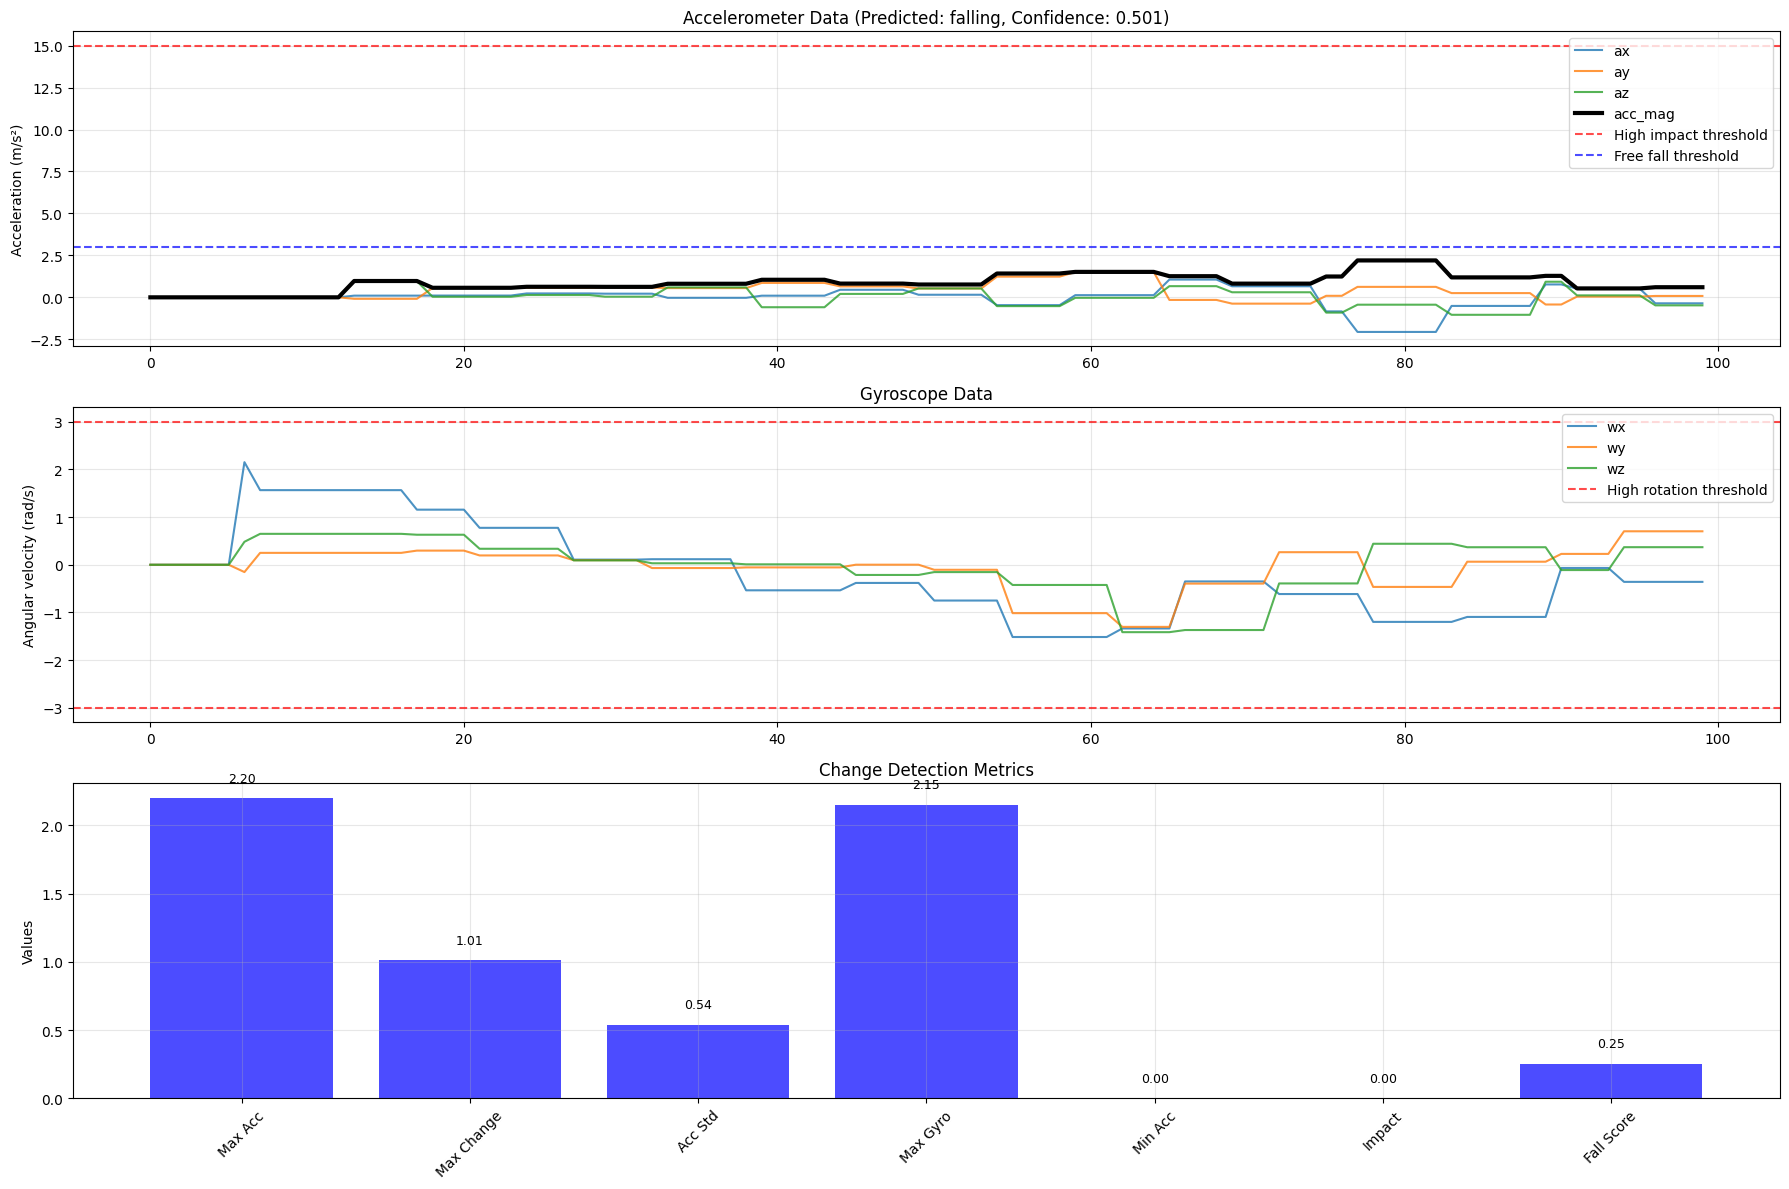


Test completed!
The enhanced model should be much more accurate at detecting falls!


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

def calculate_change_features(window_data):
    """
    Calculate drastic change indicators for a window of sensor data.
    Must match the training function exactly!
    """
    features = []
    
    # 1. Maximum acceleration magnitude
    acc_mag = np.sqrt(window_data['ax']**2 + window_data['ay']**2 + window_data['az']**2)
    max_acc = acc_mag.max()
    features.append(max_acc)
    
    # 2. Maximum change in acceleration magnitude
    acc_diff = acc_mag.diff().abs().max()
    features.append(acc_diff if not np.isnan(acc_diff) else 0)
    
    # 3. Standard deviation of acceleration
    acc_std = acc_mag.std()
    features.append(acc_std if not np.isnan(acc_std) else 0)
    
    # 4. Maximum rotational velocity
    max_gyro = max(window_data['wx'].abs().max(), 
                   window_data['wy'].abs().max(), 
                   window_data['wz'].abs().max())
    features.append(max_gyro)
    
    # 5. Free fall indicator (minimum acceleration)
    min_acc = acc_mag.min()
    features.append(min_acc)
    
    # 6. Impact indicator
    acc_values = acc_mag.values
    impact_score = 0
    for i in range(1, len(acc_values)):
        if acc_values[i-1] < 5.0 and acc_values[i] > 12.0:
            impact_score = max(impact_score, acc_values[i] - acc_values[i-1])
    features.append(impact_score)
    
    # 7. Change rate in X, Y, Z accelerations
    ax_change = window_data['ax'].diff().abs().max()
    ay_change = window_data['ay'].diff().abs().max()
    az_change = window_data['az'].diff().abs().max()
    features.extend([
        ax_change if not np.isnan(ax_change) else 0,
        ay_change if not np.isnan(ay_change) else 0,
        az_change if not np.isnan(az_change) else 0
    ])
    
    # 8. Fall pattern score
    fall_score = 0
    if max_acc > 15.0:
        fall_score += 0.3
    if min_acc < 3.0:
        fall_score += 0.25
    if acc_diff > 8.0:
        fall_score += 0.25
    if max_gyro > 3.0:
        fall_score += 0.2
    features.append(fall_score)
    
    return np.array(features).reshape(1, -1)

def test_specific_range_enhanced(model_path, test_data_path, start_index, end_index, label_column=None):
    """
    Test a specific range of data from a CSV file using the enhanced model with change detection.
    
    Parameters:
    - model_path: Path to the saved enhanced model
    - test_data_path: Path to the test CSV file
    - start_index: Start index of the range to test
    - end_index: End index of the range to test
    - label_column: Name of the label column (if exists, otherwise None)
    """
    # Load the enhanced model
    model = keras.models.load_model(model_path)
    print(f"Loaded enhanced model from {model_path}")
    
    # Load the data
    df = pd.read_csv(test_data_path)
    print(f"Loaded {len(df)} samples from {test_data_path}")
    print(f"Available columns: {df.columns.tolist()}")
    
    # Reset index if needed
    if not df.index.is_monotonic_increasing or not df.index.equals(pd.RangeIndex(len(df))):
        df = df.reset_index(drop=True)
    
    # Ensure the range is valid
    if end_index > len(df):
        raise ValueError(f"Range exceeds dataset size. Maximum allowable end index: {len(df) - 1}")
    
    # Check required columns
    required_features = ['ax', 'ay', 'az', 'wx', 'wy', 'wz']
    missing_features = [col for col in required_features if col not in df.columns]
    
    if missing_features:
        print(f"Warning: Missing required feature columns: {missing_features}")
        print("Please check your CSV file format and column names")
        return None, None, None
    
    # Add acc_mag if it doesn't exist
    if 'acc_mag' not in df.columns:
        df['acc_mag'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)
    
    # Extract sample features
    feature_columns = ['ax', 'ay', 'az', 'wx', 'wy', 'wz', 'acc_mag']
    sample = df.iloc[start_index:end_index][feature_columns]
    
    # Get true label if label column exists
    true_label = None
    if label_column is not None and label_column in df.columns:
        true_label = df.iloc[start_index:end_index][label_column].mode()[0]
        print(f"True label: {true_label}")
    else:
        print("No label column found in the data. Only prediction will be performed.")
    
    # Calculate change detection features (THIS IS THE KEY ADDITION!)
    change_features = calculate_change_features(sample)
    
    # Create enhanced features (original + change features repeated for each timestep)
    enhanced_features = np.concatenate([
        sample.values, 
        np.tile(change_features, (len(sample), 1))
    ], axis=1)
    
    # Prepare the sample for prediction
    sample_batch = np.expand_dims(enhanced_features, axis=0)
    
    # Verify shape matches model's expected input
    input_shape = model.layers[0].input_shape
    print(f"Model expects input shape: {input_shape}")
    print(f"Sample batch shape: {sample_batch.shape}")
    print(f"Original features: 7, Enhanced features: {enhanced_features.shape[1]}")
    
    # Predict using the enhanced trained model
    prediction = model.predict(sample_batch)
    
    # Get the class names (matches the training order)
    classes = ['falling', 'kneeling', 'walking']  # This matches your training
    
    # Extract probabilities
    falling_prob = float(prediction[0][0])
    kneeling_prob = float(prediction[0][1])
    walking_prob = float(prediction[0][2])
    
    # Extract change analysis features
    max_acc = float(change_features[0][0])
    max_change = float(change_features[0][1])
    acc_std = float(change_features[0][2])
    max_gyro = float(change_features[0][3])
    min_acc = float(change_features[0][4])
    impact_score = float(change_features[0][5])
    fall_score = float(change_features[0][-1])
    
    # Apply the same enhanced decision logic as in training
    if fall_score > 0.7:  # Strong rule-based indicators
        predicted_class = "falling"
        confidence = min(0.95, falling_prob + fall_score * 0.5)
    elif max_acc > 20.0:  # Extreme acceleration
        predicted_class = "falling"
        confidence = min(0.90, falling_prob + 0.4)
    elif falling_prob > 0.15:  # ML is confident about fall
        predicted_class = "falling"
        confidence = falling_prob
    elif falling_prob > 0.08 and (max_change > 10.0 or min_acc < 2.0):  # Combined evidence
        predicted_class = "falling"
        confidence = min(0.85, falling_prob + 0.3)
    elif falling_prob > 0.05 and impact_score > 8.0:  # Impact detected
        predicted_class = "falling"
        confidence = min(0.80, falling_prob + 0.35)
    else:
        # Use highest probability
        predicted_class_index = prediction.argmax(axis=1)[0]
        predicted_class = classes[predicted_class_index]
        confidence = float(prediction[0][predicted_class_index])
    
    # Print detailed results
    print(f"\n" + "="*60)
    print("ENHANCED MODEL PREDICTION RESULTS")
    print("="*60)
    print(f"Predicted activity: {predicted_class}")
    print(f"Final confidence: {min(confidence, 1.0):.4f}")
    
    if true_label is not None:
        print(f"True label: {true_label}")
        print(f"Prediction correct: {predicted_class.lower() == true_label.lower()}")
    
    print(f"\nML Model Probabilities:")
    for i, cls in enumerate(classes):
        print(f"  {cls}: {prediction[0][i]:.4f}")
    
    print(f"\nChange Detection Analysis:")
    print(f"  Max acceleration: {max_acc:.2f} m/s²")
    print(f"  Min acceleration: {min_acc:.2f} m/s²")
    print(f"  Max change rate: {max_change:.2f} m/s²")
    print(f"  Acceleration std: {acc_std:.2f} m/s²")
    print(f"  Max gyro: {max_gyro:.2f} rad/s")
    print(f"  Impact score: {impact_score:.2f}")
    print(f"  Fall pattern score: {fall_score:.2f}")
    
    print(f"\nFall Indicators:")
    print(f"  High impact (>15g): {max_acc > 15.0}")
    print(f"  Free fall (<3g): {min_acc < 3.0}")
    print(f"  Sudden change (>8g): {max_change > 8.0}")
    print(f"  High rotation (>3 rad/s): {max_gyro > 3.0}")
    print(f"  Strong fall pattern (>0.5): {fall_score > 0.5}")
    print("="*60)
    
    # Enhanced plotting with change detection info
    plt.figure(figsize=(18, 12))
    
    # Plot accelerometer data
    plt.subplot(3, 1, 1)
    plt.plot(sample['ax'], label='ax', alpha=0.8)
    plt.plot(sample['ay'], label='ay', alpha=0.8)
    plt.plot(sample['az'], label='az', alpha=0.8)
    plt.plot(sample['acc_mag'], label='acc_mag', linewidth=3, color='black')
    
    # Add threshold lines
    plt.axhline(y=15.0, color='red', linestyle='--', alpha=0.7, label='High impact threshold')
    plt.axhline(y=3.0, color='blue', linestyle='--', alpha=0.7, label='Free fall threshold')
    
    if true_label is not None:
        plt.title(f'Accelerometer Data (True: {true_label}, Predicted: {predicted_class}, Confidence: {confidence:.3f})')
    else:
        plt.title(f'Accelerometer Data (Predicted: {predicted_class}, Confidence: {confidence:.3f})')
    
    plt.ylabel('Acceleration (m/s²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot gyroscope data
    plt.subplot(3, 1, 2)
    plt.plot(sample['wx'], label='wx', alpha=0.8)
    plt.plot(sample['wy'], label='wy', alpha=0.8)
    plt.plot(sample['wz'], label='wz', alpha=0.8)
    
    # Add threshold line
    plt.axhline(y=3.0, color='red', linestyle='--', alpha=0.7, label='High rotation threshold')
    plt.axhline(y=-3.0, color='red', linestyle='--', alpha=0.7)
    
    plt.title('Gyroscope Data')
    plt.ylabel('Angular velocity (rad/s)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot change detection metrics
    plt.subplot(3, 1, 3)
    change_metrics = [max_acc, max_change, acc_std, max_gyro, min_acc, impact_score, fall_score]
    metric_names = ['Max Acc', 'Max Change', 'Acc Std', 'Max Gyro', 'Min Acc', 'Impact', 'Fall Score']
    colors = ['red' if m > [15, 8, 2, 3, 3, 8, 0.5][i] else 'blue' for i, m in enumerate(change_metrics)]
    
    bars = plt.bar(metric_names, change_metrics, color=colors, alpha=0.7)
    plt.title('Change Detection Metrics')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, change_metrics):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{value:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('enhanced_sample_prediction.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return predicted_class, confidence, true_label

# Example usage:
if __name__ == "__main__":
    print("Enhanced Fall Detection Model Tester")
    print("This version includes change detection features and enhanced decision logic\n")
    
    # Test on a specific range with the enhanced model
    predicted_class, confidence, true_label = test_specific_range_enhanced(
        model_path="/notebooks/FallDet/anti_overfitting_fall_detection_model.h5",  # Use your enhanced model
        test_data_path="Mark - falling test 1.csv",  # Your test file
        start_index=0,
        end_index=100,
        label_column=None  # Set to None since 'label' doesn't exist
    )
    
    print("\nTest completed!")
    print("The enhanced model should be much more accurate at detecting falls!")